In [126]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import median_filter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

from tqdm import tqdm

In [174]:
"""
Global Variables
"""

# Dataset path
data_path = os.path.join(os.path.sep, 'media', 'gabriel', 
                         'External_2.0_TB', 'ImageNet', 
                         '1000_classes')
classes = next(os.walk(data_path, topdown=True))[1]
classes.sort()
print(f'Number of classes found: {len(classes)}')
print("-" * 50)

# Define image processing metadata
image_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


# Instantiate torch loader and dataset
imagenet_dataset = datasets.ImageFolder(
        data_path, 
        transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)            
        ]))
dataloader = DataLoader(
        imagenet_dataset, batch_size=5,
        shuffle=True, num_workers=4)

dataloader_iter = iter(dataloader)

# Download VGG16 model from the pytorch model_zoo
vgg16 = models.vgg16(pretrained=True)
print(f'VGG16 architecture:\n{vgg16}')
print('-' * 50)

# Extract convolution blocks from the network
# Block 1
conv_1_1 = vgg16.features[0:2]
conv_1_2 = vgg16.features[:5]
# Block 2
conv_2_1 = vgg16.features[:7]
conv_2_2 = vgg16.features[:10]
# Block 3
conv_3_1 = vgg16.features[:12]
conv_3_2 = vgg16.features[:14]
conv_3_3 = vgg16.features[:17]
# Block 4
conv_4_1 = vgg16.features[:19]
conv_4_2 = vgg16.features[:21]
conv_4_3 = vgg16.features[:24]
# Block 5
conv_5_1 = vgg16.features[:26]
conv_5_2 = vgg16.features[:28]
conv_5_3 = vgg16.features[:31]
print(f'Example of a convolution block:\n{conv_2_1}')
print('-' * 50)

Number of classes found: 977
--------------------------------------------------
VGG16 architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

Class = wren, Label = 970
dim: (224, 224, 3)


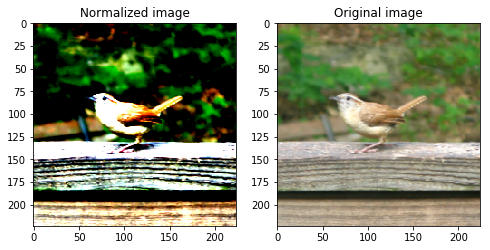

In [213]:
""" 
Sanity check: 
    Display loaded image.

Note: It will look "odd" due to normalization.
"""
# Load small batch of images for testing
images, labels = next(dataloader_iter)
image = images[0].numpy().transpose(1,2,0)
label = labels[0].item()
print(f'Class = {classes[label]}, Label = {label}')
print(f'dim: {image.shape}')

# visualize first image
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(np.clip(image, 0, 1))
plt.title('Normalized image')

"""
We can get the original image back by reverting
the normalization performed during preprocessing
"""
fig.add_subplot(1,2,2)
_image = get_unnormalized_image(image, std, mean)
plt.imshow(_image)
plt.title('Original image')
plt.show()

In [214]:
def deprocess_image(x):
    """
    Utility function to convert a float array into a valid uint8 image.
    
    Arguments
        x: A numpy-array representing the generated image.
    
    Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.25
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose(1, 2, 0)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [215]:
def display_kernels_grid(kernels, title, figsize=(16, 12), dump_path=None):
    assert len(kernels) >= (rows*cols)
    
    images_per_row = 5
    n_kernels = len(costs)//2
    size = 224
    n_cols = n_kernels // images_per_row
    shape = (size*n_cols, images_per_row*size, 3)
    display_grid = np.zeros(shape=shape, dtype=np.uint8, order='F')

    for col in range(n_cols):
        for row in range(images_per_row):
            kernel_index = costs[col][0] 
            kernel = kernels[kernel_index].cpu().detach().numpy()[0]
            kernel = deprocess_image(kernel)

            i_0, i_1 = col*size, (col + 1)*size
            j_0, j_1 = row*size, (row + 1)*size
            z_0, z_1 = 0, 3 # Channels to display
            display_grid[i_0:i_1, j_0:j_1, z_0:z_1] = kernel

    scale = 3.0/size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(title)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    
    if not dump_path == None:
        plt.savefig(f"{title}_grid.jpg", bbox_inches='tight')
    plt.show()

In [216]:
def normalize(grad):
    norm_grad = torch.sqrt(
        (grad**2).mean()) + 1e-5
    return grad/norm_grad

In [217]:
def gradient_ascent(img, kernel_index, steps=20, learning_rate=1.0, 
                    conv=None, cuda=True):
    
    # Increasing the denoise frequency increases total
    # computation time but yields higher resolution images
    denoise_freq = int(steps/10)
    
    for step in range(steps):
        random_img = Variable(img, requires_grad=True)
        random_img = random_img.cuda() if cuda else random_img
        
        out = F.relu(conv(random_img)).cuda()
        out = out.cuda() if cuda else out
        
        loss = out[:, kernel_index, :, :].mean().cuda()
        loss = loss.cuda() if cuda else loss
        loss.backward()
        
        # Normilize gradients
        norm_grad = normalize(random_img.grad)
        
        img += norm_grad * lr
        
        if step%denoise_freq == 0:
            # Denoise image
            denoised_img = median_filter(img.cpu().numpy(), size=(1,3,3,3))
            denoised_img = torch.tensor(denoised_img)
            denoised_img = denoised_img.cuda() if cuda else denoised_img
            img *= 0 
            img += denoised_img
            
        if loss.item() <= 1e-07:
            return img, loss.item()
    
    return img.detach(), loss.item()

In [218]:
def get_unnormalized_image(image, std, mean):
    _image = image * std
    _image += mean
    _image = np.clip(_image, 0, 1)
    _image *= 255 # Bound to RGB values [0-255]
    _image = _image.astype(np.uint8)
    return _image

In [219]:
def get_image_kernel(img, conv=None, cuda=True):
    
    costs = []
    
    # Move the image to the GPU if possible
    _image = img.cuda() if cuda else img.cpu()
    
    # Pass the image trhough the network and compute the 
    # activation for each kernel; ie: ReLU, Sigmoid, etc...
    out = F.relu(conv(_image)).squeeze(0)
    out = out.cuda() if cuda else out
    
    print(f"Analyzing {out.shape[0]} kernels.")

    for kernel in tqdm(out):
        # get the mean activation value for each kernel
        loss = kernel.mean().cpu()
        costs.append(loss.item())

    # cleanup
    if _image.is_cuda: _image.detach().cpu()
    if out.is_cuda: out.detach().cpu()  
    
    topk = torch.topk(torch.tensor(cost), k=1)
    kernel_index = topk.indices.item()
    
    print(costs)
        
    # Create a random image and add noise
    rimage = torch.rand(size=_image.size(), requires_grad=False).cuda()
    rimage = (rimage - 0.5) * 20 + 128
    
    # Gradient Ascent
    image_kernel, loss = gradient_ascent(rimage, kernel_index, steps=40, 
                                         learning_rate=0.75, conv=conv)
    image_kernel = image_kernel.detach().cpu().squeeze(0).numpy()
    
    return image_kernel, kernel_index, loss

In [410]:
def activate_kernel(img, kernel_index, conv=None, cuda=True):
    
    img = img.cuda() if cuda else img

    out = conv(img)
    out_activation = F.relu(out).cpu()
    
    img = img.cpu()
    
    kernel = out[:, kernel_index, :, :].cpu()
    kernel_activation = out_activation[:, kernel_index, :, :].cpu()
    
    heatmap = out[:, kernel_index, :, :].cpu().detach().numpy()
#     heatmap = np.mean(heatmap, axis=-1)
#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= np.max(heatmap)
    
    loss = kernel_activation.sum().cpu()
    
    # Mem. cleanup
    torch.cuda.empty_cache()
        
    return kernel.detach().numpy(), kernel_activation.detach().numpy(), heatmap, loss.item()

In [235]:
lr = 1.0
kernel_index = 10

conv = conv_5_3.cuda()
num_of_kernels = conv[-3].weight.shape[0]

img_size = (1, 3, 224, 224)

kernels = []
costs = []

print(f"Performing gradient ascent on {num_of_kernels} kernels")

for kernel_index in tqdm(range(num_of_kernels)):
    # Create a random image
    img = torch.rand(size=img_size, 
                     requires_grad=False).cuda()
    # Add noise to the image
    img = (img - 0.5) * 20 + 128
    
    # Gradient Ascent
    img, loss = gradient_ascent(img, kernel_index, steps=40, 
                                learning_rate=0.75, conv=conv)
    
    if img is not None:
        kernels.append(img)
        costs.append([kernel_index, loss])

  0%|          | 2/512 [00:00<00:41, 12.34it/s]

Performing gradient ascent on 512 kernels


100%|██████████| 512/512 [01:30<00:00,  5.65it/s]


# Show top-10 Filters

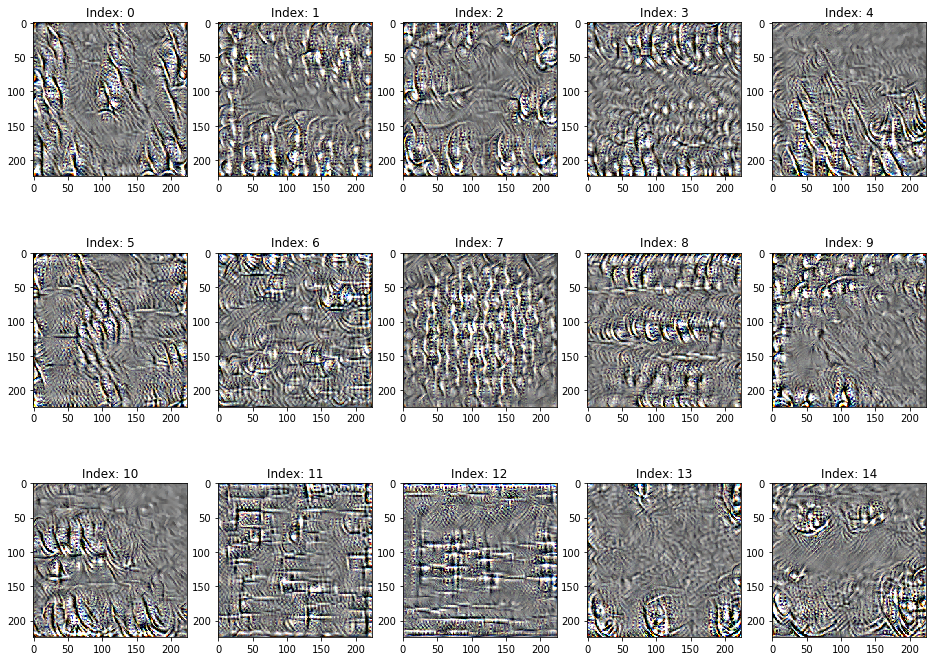

In [236]:
costs.sort(key=lambda x:x[1], reverse=True)

cols = 5
rows = 3
figsize = (16, 12) # width, height

fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
axs = axs.flatten()

for index, ax in enumerate(axs):
    kernel_index = costs[index][0] 
    kernel = kernels[kernel_index].cpu().detach().numpy()[0]
    kernel = deprocess_image(kernel)

    ax.set_title("Index: %s" % (index))
    ax.imshow(kernel)

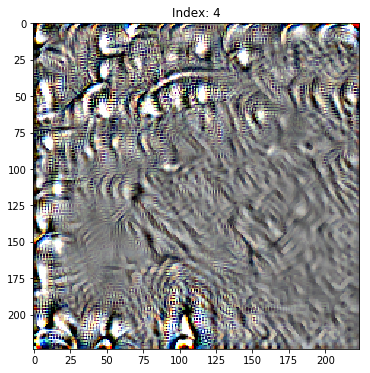

In [237]:
cols = 1
rows = 1
figsize = (6, 6) # width, height

fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
ax = ax.flatten()

index = costs[9][0] 

kernel = kernels[index].cpu().detach().numpy()[0]
kernel = deprocess_image(kernel)

ax[0].set_title("Index: %s" % 4)
ax[0].imshow(kernel)

plt.show()

In [238]:
costs[:10]

[[91, 658.3310546875],
 [215, 602.74658203125],
 [280, 507.65313720703125],
 [11, 283.19879150390625],
 [471, 278.48175048828125],
 [236, 267.9792175292969],
 [148, 265.3009033203125],
 [355, 252.018310546875],
 [348, 244.64906311035156],
 [403, 242.6122589111328]]

# Display filters with highest activation : To-Do

In [276]:
conv_1_1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)

In [411]:
"""
Now we will pass an image for a particular class and visualize the kernels that 
provides the highest activation for images of that class
"""
# img_size = (1, 3, 224, 224)
_image = images[0].unsqueeze(dim=0)
_label = labels[0]
_class = classes[_label]

conv = conv_1_1.cuda()
num_of_kernels = conv_1_1[0].weight.shape[0]

print(f'Class = {_class}, Label = {_label}')

# Store metadata
outputs = []
out_activations = []
heatmaps = []
activation_costs = []

for kernel_index in range(num_of_kernels):
    _out, _out_activation, heatmap, cost = activate_kernel(_image, kernel_index, conv[0])
    outputs.append(_out)
    out_activations.append(_out_activation)
    heatmaps.append(heatmap)
    activation_costs.append(cost)

# Memory cleanup
torch.cuda.empty_cache()

Class = wren, Label = 970


In [412]:
topk = torch.topk(torch.Tensor(activation_costs), k=5)
topk

torch.return_types.topk(
values=tensor([43765.9375, 39647.2656, 37690.4258, 34432.0352, 34216.3242]),
indices=tensor([57, 28, 48,  4, 38]))

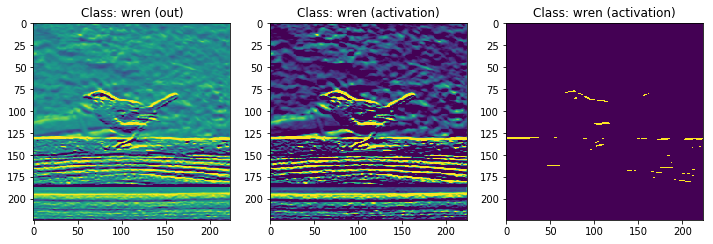

In [432]:
import torch.nn.functional as F

# kernel_index = topk.indices[0]
# kernel = kernels[kernel_index].detach().cpu().numpy()[0]
# kernel = deprocess_image(kernel)
# cost = costs[kernel_index]

filter_index = topk.indices[0]

out = deprocess_image(outputs[filter_index])
out = np.squeeze(out, 2)

out_activation = deprocess_image(out_activations[filter_index])
out_activation = np.squeeze(out_activation, 2)
out_activation = np.round(out_activation)

# To-Do
heatmap = heatmaps[filter_index]
heatmap = np.mean(heatmap, 0)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = np.round(heatmap)

figure = plt.figure(figsize=(12,12))
figure.add_subplot(1,3,1)
plt.imshow(out)
plt.title(f'Class: {_class} (out)')

figure.add_subplot(1,3,2)
plt.imshow(out_activation)
_ = plt.title(f'Class: {_class} (activation)')

figure.add_subplot(1,3,3)
plt.imshow(heatmap)
_ = plt.title(f'Class: {_class} (activation)')

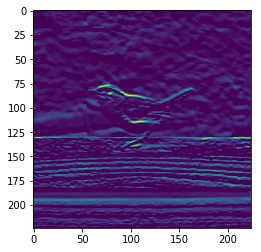

In [444]:
heatmap = out_activations[filter_index]
# heatmap = np.squeeze(heatmap)
heatmap = np.mean(heatmap, 0)
heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
# heatmap = np.round(heatmap)
heatmap.shape

plt.imshow(heatmap)

In [230]:
def get_image_kernel(img, conv=None, cuda=True):
    
    costs = []
    
    # Move the image to the GPU if possible
    _image = img.cuda() if cuda else img.cpu()
    
    # Pass the image trhough the network and compute the 
    # activation for each kernel; ie: ReLU, Sigmoid, etc...
    out = F.relu(conv(_image)).squeeze(0)
    out = out.cuda() if cuda else out
    
    print(f"Analyzing {out.shape[0]} kernels.")

    for kernel in tqdm(out):
        # get the mean activation value for each kernel
        loss = kernel.mean().cpu()
        costs.append(loss.item())

    # cleanup
    if _image.is_cuda: _image.detach().cpu()
    if out.is_cuda: out.detach().cpu()  
    
    topk = torch.topk(torch.tensor(costs), k=1)
    kernel_index = topk.indices.item()
    
    print(topk)
        
    # Create a random image and add noise
    rimage = torch.rand(size=_image.size(), requires_grad=False).cuda()
    rimage = (rimage - 0.5) * 20 + 128
    
    # Gradient Ascent
    image_kernel, loss = gradient_ascent(rimage, kernel_index, steps=40, 
                                         learning_rate=0.75, conv=conv)
    image_kernel = image_kernel.detach().cpu().squeeze(0).numpy()
    
    return image_kernel, kernel_index, loss

In [253]:
_image = images[0].unsqueeze(0)
kernel, index, loss = get_image_kernel(_image, conv, cuda=True)

100%|██████████| 512/512 [00:00<00:00, 20810.16it/s]

Analyzing 512 kernels.
torch.return_types.topk(
values=tensor([4.2138]),
indices=tensor([425]))


In [256]:
index, loss

(425, 0.0)

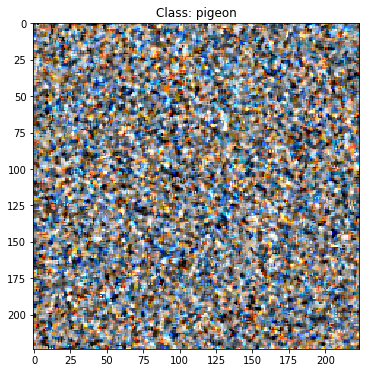

In [257]:
cols = 1
rows = 1
figsize = (6, 6) # width, height

fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
ax = ax.flatten()

_kernel = deprocess_image(kernel)
ax[0].set_title(f"Class: {classes[labels[0].item()]}")
ax[0].imshow(_kernel)
plt.show()

In [261]:
np.array(classes)[labels.numpy()]

array(['pigeon', 'foxglove', 'cricket', 'roller skating', 'sweater'],
      dtype='<U25')